In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 17})
%matplotlib inline

## Full set of equations

We take the observable state $s$ to live in a discretized field of $N$ total states that are sampled uniformely at each iteration and $z$ to be a binary variable that is zero in one half of the state distribution and one in the other half.

* $d(s,z) = KL[\pi(a|s)||\pi(a|z)]$
* $p(z) = \sum_s p(s)\rho(z|s)$
    * $ = \tau \sum_s \rho(z|s)$
* $Z(s,\beta) = \sum_z p(z) e^{-\beta d(s,z)}$
* $p(s) = \tau$, we define the observed state distribution as an uniform distribution
* $\pi(a|s)$ - we define this distribution as the optimal solution to the problem
* $\rho(z|s) = \frac{p(z)}{Z(s,\beta)}e^{-\beta d(z,s)}$
* $\rho(s|z) \propto \rho(z|s) p(s)$
* $\pi(a|z) = \sum_a \pi(a|s)\rho(s|z)$  

## Algorithm steps:


### Goals:

1. Prove that this set of equations converge to what's expected in $\pi(a|z)$

### Tasks:
1. Rederive the set of iterative equations 

In [2]:
# auxiliary functions

def KL_div(pi_s, pi_z):
    # pi_s[a,s], pi_z[a,z]
    
    kldiv = 0
    
    n_states = pi_s.shape[1]
    n_latent = pi_z.shape[1]
    n_actions = pi_s.shape[0]
    
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                kldiv += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])
    return kldiv

def get_d_sz(pi_s,pi_z):
    # pi_s[a,s], pi_z[a,z]
    
    n_states = pi_s.shape[1]
    n_latent = pi_z.shape[1]
    n_actions = pi_s.shape[0]
    
    d_sz = np.zeros((n_states, n_latent))
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                d_sz[s,z] += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])
    return d_sz

def normalize_dist(dist):
    return dist/np.sum(dist)

1.0 1.0


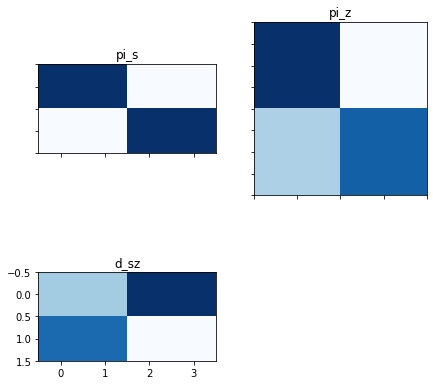

1.0 1.0


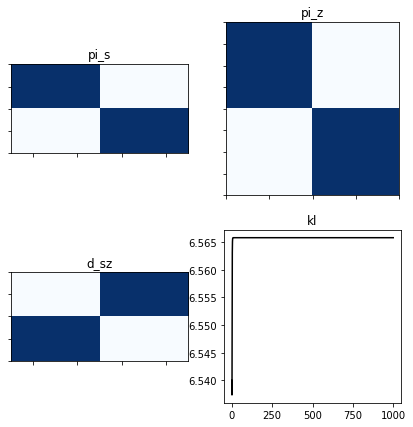

In [20]:
# global variables
n_states = 4 # definition of s
n_latent = 2 # definition of z
n_actions = 2 # definition of a

# iterative functions
p_s = 1/n_states - 0.001 # uniform probability for each state - added help of normalization
p_z = np.array([0.25,0.25])
p_z = normalize_dist(p_z)

pi_s = 0.001 * np.ones((n_actions, n_states))

#pi_z = 0.001 * np.ones((n_actions, n_latent))
#pi_z[0,0] = 0.1
#pi_z[1,1] = 0.1
#pi_z = normalize_dist(pi_z)

pi_z = normalize_dist(np.random.uniform(0,1,(n_latent, n_actions)))

d_sz = np.zeros((n_states, n_latent))
Z_sb = np.zeros((n_states))

rho_sz = np.zeros((n_states, n_latent))
rho_zs = np.zeros((n_latent, n_states))

pi_s[0,0:int(n_states/2)] = 1
pi_s[1,int(n_states/2):n_states] = 1
pi_s = normalize_dist(pi_s)

# defining the p(s,z) joint distribution - later try it out with gaussian
p_sz = np.zeros((n_states, n_latent))
p_sz[:,0] = pi_s[0,:]
p_sz[:,1] = pi_s[1,:]
p_sz = normalize_dist(p_sz)

p_sa = np.zeros((n_states, n_actions))
p_sa[:,0] = pi_s[0,:]
p_sa[:,1] = pi_s[1,:]
p_sa = normalize_dist(p_sa)

# -------

kldiv_h = []

p_z_h = []
pi_z_h = []
rho_zs_h = []
d_sz_h = []
z_sb_h = []

print_vars = False
check_norms = True
pi_s_h = []

print(p_z.sum(), pi_z.sum())

fig = plt.figure(figsize = [7,7])

gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

d_sz = get_d_sz(pi_s, pi_z)
ax1.imshow(pi_s, cmap = 'Blues')
ax2.imshow(pi_z, cmap = 'Blues')
ax3.imshow(d_sz.T, cmap = 'Blues')
ax1.set_title('pi_s')
ax2.set_title('pi_z')
ax3.set_title('d_sz')
ax1.tick_params(labelbottom=False, labelleft=False)
ax2.tick_params(labelbottom=False, labelleft=False)
plt.show()

# --------

beta = 2
n_steps = 1000 # number of iterative steps

print(p_z.sum(), pi_z.sum())

for t in range(n_steps):
    
    d_sz = get_d_sz(pi_s, pi_z)
    d_sz_h.append(d_sz)
    
    # update Z_sb
    Z_sb = np.zeros((n_states))
    for s in range(n_states):
        for z in range(n_latent):
            Z_sb[s] += p_z[z] * np.exp(-beta * d_sz[s,z])
    
    # update rho_zs
    for s in range(n_states):
        for z in range(n_latent):
            rho_zs[z,s] = (p_z[z]/Z_sb[s]) * np.exp(-beta * d_sz[s,z])
    
    # update p_z
    p_z = np.zeros(n_latent)
    for z in range(n_latent):
        for s in range(n_states):
            p_z[z] += rho_zs[z,s] * p_s
    
    # update pi_z
    pi_z = np.zeros((n_actions, n_latent))
    for a in range(n_actions):
        for z in range(n_latent):
            for s in range(n_states):
                pi_z[a,z] +=  p_s * pi_s[a,s] * rho_zs[z,s] / p_z[z]
    
    #print(t, p_z.sum(), pi_z.sum())
    
    # keeping the histories
    p_z_h.append(p_z)
    rho_zs_h.append(rho_zs)
    pi_z_h.append(pi_z)
    kldiv_h.append(KL_div(pi_s, pi_z))
    z_sb_h.append(Z_sb)
    pi_s_h.append(pi_s)

d_sz_h = np.asarray(d_sz_h)
p_z_h = np.asarray(p_z_h)
rho_zs_h = np.asarray(rho_zs_h)
pi_z_h = np.asarray(pi_z_h)
pi_s_h = np.asarray(pi_s_h)
kldiv_h = np.asarray(kldiv_h)
z_sb_h = np.asarray(z_sb_h)

fig = plt.figure(figsize = [7,7])

gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

ax1.imshow(pi_s, cmap = 'Blues')
ax2.imshow(pi_z_h[-1], cmap = 'Blues')
ax3.imshow(d_sz_h[-1].T, cmap = 'Blues')
ax4.plot(kldiv_h, 'k')
ax1.set_title('pi_s')
ax2.set_title('pi_z')
ax3.set_title('d_sz')
ax4.set_title('kl')
ax1.tick_params(labelbottom=False, labelleft=False)
ax2.tick_params(labelbottom=False, labelleft=False)
ax3.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [9]:
pi_z_h[-1]

array([[0.23968064, 0.01031936],
       [0.01031936, 0.23968064]])

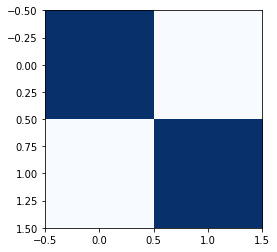

In [10]:
plt.imshow(pi_z_h[-1], 'Blues')

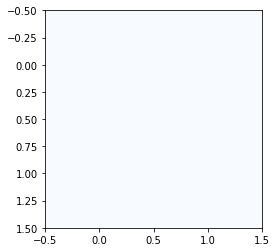

In [8]:
plt.imshow(np.asarray([[0.25,0.25],[0.25,0.25]]), 'Blues')

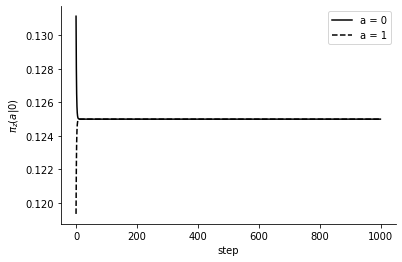

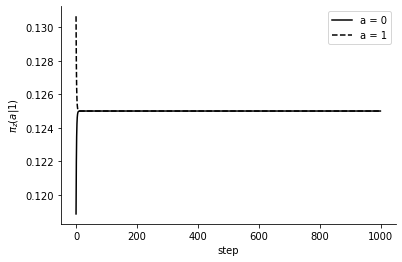

In [94]:
ax = plt.subplot(111)
ax.plot(pi_z_h[:,0,0], 'k', label = 'a = 0')
ax.plot(pi_z_h[:,0,1], 'k--', label = 'a = 1')
ax.set_xlabel('step')
ax.set_ylabel('$\pi_z(a|0)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

ax = plt.subplot(111)
ax.plot(pi_z_h[:,1,0], 'k', label = 'a = 0')
ax.plot(pi_z_h[:,1,1], 'k--',label = 'a = 1')
ax.set_xlabel('step')
ax.set_ylabel('$\pi_z(a|1)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

## undersanding the distance metric $d(s,z)$

In [290]:
## global variables
n_states = 2 # definition of s
n_latent = 2 # definition of z
n_actions = 2 # definition of a



pi_s = 0.001 * np.ones((n_actions, n_states))
#pi_s[0,0] = 1-beta
#pi_s[1,1] = 1-alpha
pi_s = normalize_dist(pi_s)

beta = 0.1
alpha = 0.1
pi_z = 0.001 * np.ones((n_actions, n_latent))
pi_z[0,0] = 0.001+beta
pi_z[1,1] = 0.001+alpha
pi_z = normalize_dist(pi_z)

In [291]:
pi_s

array([[0.25, 0.25],
       [0.25, 0.25]])

In [292]:
pi_z

array([[0.49509804, 0.00490196],
       [0.00490196, 0.49509804]])

In [279]:
pi_s - pi_z

array([[-0.2450495,  0.2450495],
       [ 0.2450495, -0.2450495]])

In [307]:
d_sz = np.zeros((n_states, n_latent))
log_sz = np.zeros((n_states, n_latent))
kl_sza = 0
for s in range(n_states):
    for z in range(n_latent):
        for a in range(n_actions):
            d_sz[s,z] += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])
            log_sz[s,z] += np.log(pi_z[a,z]/pi_s[a,s])
            kl_sza += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])

In [308]:
kl_sza

2.720784508325146

In [322]:
kl_sza = []
x = np.linspace(0.1,2,50)
for i,beta in enumerate(x):
    kl_sza.append([0])
    pi_z = 0.001 * np.ones((n_actions, n_latent))
    pi_z[0,0] = 0.001+beta
    pi_z = normalize_dist(pi_z)
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                kl_sza[i] += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])

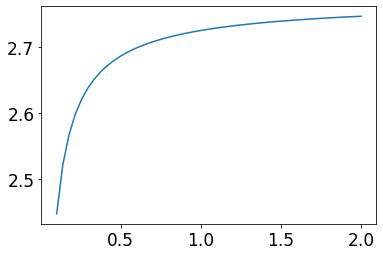

In [323]:
plt.plot(x, kl_sza)

In [281]:
kl_sza

1.275202210582107

In [282]:
log_sz

array([[-3.23877649, -3.23877649],
       [-3.23877649, -3.23877649]])

In [283]:
d_sz

array([[0.31880055, 0.31880055],
       [0.31880055, 0.31880055]])

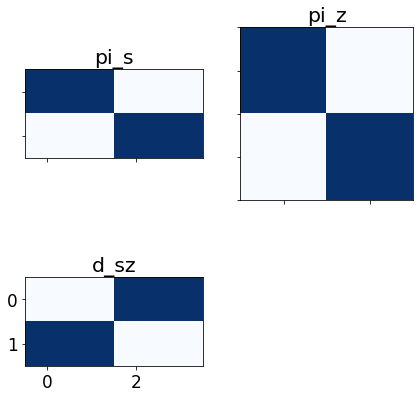

In [74]:
fig = plt.figure(figsize = [7,7])

gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

d_sz = get_d_sz(pi_s, pi_z)
ax1.imshow(pi_s, cmap = 'Blues')
ax2.imshow(pi_z, cmap = 'Blues')
ax3.imshow(d_sz.T, cmap = 'Blues')
ax1.set_title('pi_s')
ax2.set_title('pi_z')
ax3.set_title('d_sz')
ax1.tick_params(labelbottom=False, labelleft=False)
ax2.tick_params(labelbottom=False, labelleft=False)
plt.show()

# running IB multiple times, average over $\pi_z$

In [ ]:
def run_IB(n_iters):
    
    pi_z_trials = []
    
    for n in range(n_iters):
        
        # global variables
        n_states = 4 # definition of s
        n_latent = 2 # definition of z
        n_actions = 2 # definition of a

        # iterative functions
        p_s = 1/n_states - 0.001 # uniform probability for each state - added help of normalization
        p_z = np.array([0.25,0.25])
        p_z = normalize_dist(p_z)

        pi_s = 0.001 * np.ones((n_actions, n_states))
        pi_s[0,0:int(n_states/2)] = 1
        pi_s[1,int(n_states/2):n_states] = 1
        pi_s = normalize_dist(pi_s)
        pi_z = normalize_dist(np.random.uniform(0,1,(n_latent, n_actions)))

        d_sz = np.zeros((n_states, n_latent))
        Z_sb = np.zeros((n_states))
        rho_zs = np.zeros((n_latent, n_states))

        beta = 2.5
        n_steps = 100 # number of iterative steps

        for t in range(n_steps):

            d_sz = get_d_sz(pi_s, pi_z)

            # update Z_sb
            Z_sb = np.zeros((n_states))
            for s in range(n_states):
                for z in range(n_latent):
                    Z_sb[s] += p_z[z] * np.exp(-beta * d_sz[s,z])

            # update rho_zs
            for s in range(n_states):
                for z in range(n_latent):
                    rho_zs[z,s] = (p_z[z]/Z_sb[s]) * np.exp(-beta * d_sz[s,z])

            # update p_z
            p_z = np.zeros(n_latent)
            for z in range(n_latent):
                for s in range(n_states):
                    p_z[z] += rho_zs[z,s] * p_s

            # update pi_z
            pi_z = np.zeros((n_actions, n_latent))
            for a in range(n_actions):
                for z in range(n_latent):
                    for s in range(n_states):
                        pi_z[a,z] +=  p_s * pi_s[a,s] * rho_zs[z,s] / p_z[z]

        pi_z_trials.append(pi_z)
                          
    return np.asarray(pi_z_trials)

In [ ]:
pi_z_t = run_IB(1000)

In [ ]:
np.mean(pi_z_t, axis = 0)

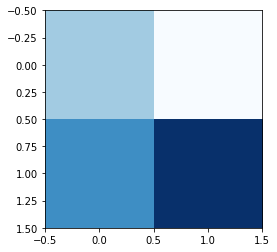

In [84]:
plt.imshow(np.mean(pi_z_t, axis = 0), 'Blues')

* at 30 iters very reliable
* at 100 less so, 1000 almost random (?)
* what's with the convergence properties of this algorithm?
* how does it scale with number of states?
    * doesn't converge with 100 trials - increase n_steps